In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import transformers
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import hamming_loss, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import json
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    print("CPU mode - training will be slower")

Using device: cuda
GPU: Tesla T4
VRAM: 14.74 GB


In [ ]:
df = pd.read_csv('/kaggle/input/dataset-preprocessed-final/dataset_preprocessed_final.csv')

print("Dataset Info:")
print(f"Shape: {df.shape}")
print(f"First few texts:\n{df['text_clean'].head()}\n")

emotion_cols = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 
                'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 
                'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 
                'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 
                'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 
                'neutral']

print(f"Number of emotion labels: {len(emotion_cols)}")
print(f"Emotions: {emotion_cols}\n")

X = df['text_clean'].values
y = df[emotion_cols].values

print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Sample text: {X[0][:100]}...")
print(f"Sample labels: {y[0]}")
print(f"Emotions for first sample: {[emotion_cols[i] for i in range(len(emotion_cols)) if y[0][i] == 1]}")

Dataset Info:
Shape: (57561, 29)
First few texts:
0               omg person is so cute in this artstyle
1    my liver cries watching these kids. weeps into...
2    sadly, the military is archaic about non-confo...
3    everytime i wore white pants! finally got an a...
4                                   but person is fine
Name: text_clean, dtype: object

Number of emotion labels: 28
Emotions: ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']

Features shape: (57561,)
Labels shape: (57561, 28)
Sample text: omg person is so cute in this artstyle...
Sample labels: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Emotions for first sample: ['admiration']


In [ ]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

print(f"Using model: {model_name}")
print(f"Tokenizer vocabulary size: {len(tokenizer)}")

def tokenize_texts(texts, max_length=256, batch_size=32):
    """Tokenize texts with BERT tokenizer"""
    input_ids = []
    attention_masks = []
    
    print(f"Tokenizing {len(texts)} texts...")
    for text in tqdm(texts):
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors=None
        )
        input_ids.append(encoding['input_ids'])
        attention_masks.append(encoding['attention_mask'])
    
    return np.array(input_ids), np.array(attention_masks)

input_ids, attention_masks = tokenize_texts(X, max_length=256)

print(f"\nInput IDs shape: {input_ids.shape}")
print(f"Attention masks shape: {attention_masks.shape}")
print(f"Sample input IDs (first 20 tokens): {input_ids[0][:20]}")
print(f"Sample attention mask (first 20 tokens): {attention_masks[0][:20]}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Using model: bert-base-uncased
Tokenizer vocabulary size: 30522
Tokenizing 57561 texts...


100%|██████████| 57561/57561 [00:10<00:00, 5326.77it/s]



Input IDs shape: (57561, 256)
Attention masks shape: (57561, 256)
Sample input IDs (first 20 tokens): [  101 18168  2290  2711  2003  2061 10140  1999  2023  2840 27983   102
     0     0     0     0     0     0     0     0]
Sample attention mask (first 20 tokens): [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]


In [ ]:
X_train_ids, X_temp_ids, X_train_mask, X_temp_mask, y_train, y_temp = train_test_split(
    input_ids, attention_masks, y, test_size=0.2, random_state=42
)

X_val_ids, X_test_ids, X_val_mask, X_test_mask, y_val, y_test = train_test_split(
    X_temp_ids, X_temp_mask, y_temp, test_size=0.5, random_state=42
)

print(f"Train set size: {len(X_train_ids)}")
print(f"Validation set size: {len(X_val_ids)}")
print(f"Test set size: {len(X_test_ids)}")

X_train_ids = torch.tensor(X_train_ids, dtype=torch.long)
X_train_mask = torch.tensor(X_train_mask, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_val_ids = torch.tensor(X_val_ids, dtype=torch.long)
X_val_mask = torch.tensor(X_val_mask, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.float32)

X_test_ids = torch.tensor(X_test_ids, dtype=torch.long)
X_test_mask = torch.tensor(X_test_mask, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.float32)

batch_size = 16

train_dataset = TensorDataset(X_train_ids, X_train_mask, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val_ids, X_val_mask, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TensorDataset(X_test_ids, X_test_mask, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nDataLoaders created successfully!")

Train set size: 46048
Validation set size: 5756
Test set size: 5757

DataLoaders created successfully!


In [ ]:
class FlatBERT(nn.Module):
    """
    F-BERT: Flat BERT for Multi-Label Emotion Classification
    - Single BERT encoder
    - Direct multi-label prediction
    - Simple architecture
    """
    def __init__(self, model_name, num_labels, dropout_rate=0.3):
        super(FlatBERT, self).__init__()
        
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        self.fc1 = nn.Linear(768, 256)
        self.fc2 = nn.Linear(256, num_labels)
        
        self.loss_fn = nn.BCELoss()
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        
        cls_output = outputs.last_hidden_state[:, 0, :]
        
        x = self.dropout(cls_output)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        logits = self.sigmoid(x)
        
        return logits
    
    def compute_loss(self, logits, labels):
        return self.loss_fn(logits, labels)

print("✓ FlatBERT model class defined")

✓ FlatBERT model class defined


In [ ]:
class HierarchicalBERT(nn.Module):
    """
    H-BERT: Hierarchical BERT for Multi-Label Emotion Classification
    - Single BERT encoder
    - Two-level hierarchy: Categories → Emotions
    - Separate heads for each level
    """
    def __init__(self, model_name, num_emotions, num_categories, dropout_rate=0.3):
        super(HierarchicalBERT, self).__init__()
        
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout_rate)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        self.shared_fc = nn.Linear(768, 256)
        
        self.category_fc1 = nn.Linear(256, 128)
        self.category_fc2 = nn.Linear(128, num_categories)
        
        self.emotion_fc1 = nn.Linear(256 + num_categories, 256)
        self.emotion_fc2 = nn.Linear(256, num_emotions)
        
        self.loss_fn = nn.BCELoss()
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        
        shared = self.dropout(cls_output)
        shared = self.shared_fc(shared)
        shared = self.relu(shared)
        
        cat = self.dropout(shared)
        cat = self.category_fc1(cat)
        cat = self.relu(cat)
        cat = self.dropout(cat)
        category_logits = self.sigmoid(self.category_fc2(cat))
        
        emo = self.dropout(shared)
        emo = torch.cat([emo, category_logits], dim=1)
        emo = self.emotion_fc1(emo)
        emo = self.relu(emo)
        emo = self.dropout(emo)
        emotion_logits = self.sigmoid(self.emotion_fc2(emo))
        
        return emotion_logits, category_logits
    
    def compute_loss(self, emotion_logits, category_logits, emotion_labels, category_labels):
        emotion_loss = self.loss_fn(emotion_logits, emotion_labels)
        category_loss = self.loss_fn(category_logits, category_labels)
        
        total_loss = 0.7 * emotion_loss + 0.3 * category_loss
        return total_loss, emotion_loss, category_loss

print("✓ HierarchicalBERT model class defined")

✓ HierarchicalBERT model class defined


In [ ]:
emotion_hierarchy = {
    'positive': ['admiration', 'amusement', 'approval', 'caring', 'desire', 
                'excitement', 'gratitude', 'joy', 'love', 'optimism', 'pride', 'relief', 'surprise'],
    'negative': ['anger', 'annoyance', 'disappointment', 'disapproval', 'disgust', 
                'embarrassment', 'fear', 'grief', 'nervousness', 'remorse', 'sadness'],
    'ambiguous': ['confusion', 'curiosity', 'realization', 'neutral']
}

def create_hierarchy_labels(y, emotion_cols, hierarchy):
    """Create hierarchical category labels"""
    y_hierarchy = np.zeros((len(y), len(hierarchy)))
    
    for cat_idx, (category, emotions) in enumerate(hierarchy.items()):
        emotion_indices = [emotion_cols.index(e) for e in emotions if e in emotion_cols]
        
        y_hierarchy[:, cat_idx] = y[:, emotion_indices].max(axis=1)
    
    return y_hierarchy

y_train_hier = create_hierarchy_labels(y_train.numpy(), emotion_cols, emotion_hierarchy)
y_val_hier = create_hierarchy_labels(y_val.numpy(), emotion_cols, emotion_hierarchy)
y_test_hier = create_hierarchy_labels(y_test.numpy(), emotion_cols, emotion_hierarchy)

y_train_hier = torch.tensor(y_train_hier, dtype=torch.float32)
y_val_hier = torch.tensor(y_val_hier, dtype=torch.float32)
y_test_hier = torch.tensor(y_test_hier, dtype=torch.float32)

print(f"Emotion hierarchy created:")
for category, emotions in emotion_hierarchy.items():
    print(f"  {category:12s}: {len(emotions):2d} emotions")

print(f"\nHierarchical labels shape: {y_train_hier.shape}")

Emotion hierarchy created:
  positive    : 13 emotions
  negative    : 11 emotions
  ambiguous   :  4 emotions

Hierarchical labels shape: torch.Size([46048, 3])


In [ ]:
num_labels = len(emotion_cols)
num_categories = len(emotion_hierarchy)

fbert = FlatBERT(model_name, num_labels, dropout_rate=0.3)
fbert = fbert.to(device)

hbert = HierarchicalBERT(model_name, num_labels, num_categories, dropout_rate=0.3)
hbert = hbert.to(device)

print(f"F-BERT Model initialized:")
print(f"  Architecture: FLAT")
print(f"  Number of emotions: {num_labels}")
print(f"  Total parameters: {sum(p.numel() for p in fbert.parameters()):,}")
print(f"\nH-BERT Model initialized:")
print(f"  Architecture: HIERARCHICAL (2-level)")
print(f"  Number of emotions: {num_labels}")
print(f"  Number of categories: {num_categories}")
print(f"  Total parameters: {sum(p.numel() for p in hbert.parameters()):,}")

2025-12-10 01:34:33.884549: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765330474.120816      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765330474.191198      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

F-BERT Model initialized:
  Architecture: FLAT
  Number of emotions: 28
  Total parameters: 109,686,300

H-BERT Model initialized:
  Architecture: HIERARCHICAL (2-level)
  Number of emotions: 28
  Number of categories: 3
  Total parameters: 109,786,143


In [ ]:
num_epochs = 3
learning_rate = 2e-5
weight_decay = 0.01
patience = 2

print(f"Training Configuration:")
print(f"  Epochs: {num_epochs}")
print(f"  Learning rate: {learning_rate}")
print(f"  Weight decay: {weight_decay}")
print(f"  Batch size: {batch_size}")
print(f"  Early stopping patience: {patience}")

Training Configuration:
  Epochs: 3
  Learning rate: 2e-05
  Weight decay: 0.01
  Batch size: 16
  Early stopping patience: 2


In [16]:
def train_fbert_epoch(model, train_loader, optimizer, scheduler, device):
    """Train F-BERT for one epoch"""
    model.train()
    total_loss = 0
    
    for input_ids, attention_mask, labels in tqdm(train_loader, desc="Training"):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = model.compute_loss(logits, labels)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

def train_hbert_epoch(model, train_loader, optimizer, scheduler, device):
    """Train H-BERT for one epoch"""
    model.train()
    total_loss = 0
    
    for input_ids, attention_mask, emotion_labels, category_labels in tqdm(train_loader, desc="Training"):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        emotion_labels = emotion_labels.to(device)
        category_labels = category_labels.to(device)
        
        optimizer.zero_grad()
        emotion_logits, category_logits = model(input_ids, attention_mask)
        loss, _, _ = model.compute_loss(emotion_logits, category_logits, emotion_labels, category_labels)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

def validate_fbert(model, val_loader, device, threshold=0.5):
    """Validate F-BERT"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for input_ids, attention_mask, labels in tqdm(val_loader, desc="Validating"):
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)
            
            logits = model(input_ids, attention_mask)
            loss = model.compute_loss(logits, labels)
            total_loss += loss.item()
            
            preds = (logits > threshold).cpu().numpy()
            all_preds.append(preds)
            all_labels.append(labels.cpu().numpy())
    
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    
    hamming = hamming_loss(all_labels, all_preds)
    f1_micro = f1_score(all_labels, all_preds, average='micro', zero_division=0)
    f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    
    return total_loss / len(val_loader), hamming, f1_micro, f1_macro, all_preds, all_labels

def validate_hbert(model, val_loader, device, threshold=0.5):
    """Validate H-BERT"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for input_ids, attention_mask, emotion_labels, category_labels in tqdm(val_loader, desc="Validating"):
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            emotion_labels = emotion_labels.to(device)
            category_labels = category_labels.to(device)
            
            emotion_logits, category_logits = model(input_ids, attention_mask)
            loss, _, _ = model.compute_loss(emotion_logits, category_logits, emotion_labels, category_labels)
            total_loss += loss.item()
            
            preds = (emotion_logits > threshold).cpu().numpy()
            all_preds.append(preds)
            all_labels.append(emotion_labels.cpu().numpy())
    
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    
    hamming = hamming_loss(all_labels, all_preds)
    f1_micro = f1_score(all_labels, all_preds, average='micro', zero_division=0)
    f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    
    return total_loss / len(val_loader), hamming, f1_micro, f1_macro, all_preds, all_labels

print("✓ Training and validation functions defined")

✓ Training and validation functions defined


In [ ]:
fbert_optimizer = optim.AdamW(fbert.parameters(), lr=learning_rate, weight_decay=weight_decay)
fbert_total_steps = len(train_loader) * num_epochs
fbert_scheduler = get_linear_schedule_with_warmup(
    fbert_optimizer,
    num_warmup_steps=0,
    num_training_steps=fbert_total_steps
)

fbert_history = {
    'train_loss': [],
    'val_loss': [],
    'val_hamming': [],
    'val_f1_micro': [],
    'val_f1_macro': []
}

best_fbert_f1 = 0
fbert_patience_counter = 0

print("\n" + "="*70)
print("TRAINING F-BERT (FLAT STRUCTURE)")
print("="*70)

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    print("-" * 70)
    
    train_loss = train_fbert_epoch(fbert, train_loader, fbert_optimizer, fbert_scheduler, device)
    fbert_history['train_loss'].append(train_loss)
    print(f"Train Loss: {train_loss:.4f}")
    
    val_loss, hamming, f1_micro, f1_macro, _, _ = validate_fbert(fbert, val_loader, device)
    fbert_history['val_loss'].append(val_loss)
    fbert_history['val_hamming'].append(hamming)
    fbert_history['val_f1_micro'].append(f1_micro)
    fbert_history['val_f1_macro'].append(f1_macro)
    
    print(f"Val Loss: {val_loss:.4f}")
    print(f"Hamming Loss: {hamming:.4f}")
    print(f"F1 Score (Micro): {f1_micro:.4f}")
    print(f"F1 Score (Macro): {f1_macro:.4f}")
    
    if f1_macro > best_fbert_f1:
        best_fbert_f1 = f1_macro
        fbert_patience_counter = 0
        torch.save(fbert.state_dict(), '/kaggle/working/best_fbert_model.pt')
        print("✓ Best model saved!")
    else:
        fbert_patience_counter += 1
        if fbert_patience_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch + 1} epochs")
            break

print("\n✓ F-BERT Training completed!")
fbert.load_state_dict(torch.load('/kaggle/working/best_fbert_model.pt'))
print("✓ Best F-BERT model loaded!")


TRAINING F-BERT (FLAT STRUCTURE)

Epoch 1/3
----------------------------------------------------------------------


Training: 100%|██████████| 2878/2878 [33:15<00:00,  1.44it/s]


Train Loss: 0.1668


Validating: 100%|██████████| 360/360 [01:22<00:00,  4.39it/s]


Val Loss: 0.1261
Hamming Loss: 0.0400
F1 Score (Micro): 0.2561
F1 Score (Macro): 0.1193
✓ Best model saved!

Epoch 2/3
----------------------------------------------------------------------


Training: 100%|██████████| 2878/2878 [33:26<00:00,  1.43it/s]


Train Loss: 0.1290


Validating: 100%|██████████| 360/360 [01:21<00:00,  4.39it/s]


Val Loss: 0.1212
Hamming Loss: 0.0393
F1 Score (Micro): 0.3299
F1 Score (Macro): 0.2226
✓ Best model saved!

Epoch 3/3
----------------------------------------------------------------------


Training: 100%|██████████| 2878/2878 [33:26<00:00,  1.43it/s]


Train Loss: 0.1199


Validating: 100%|██████████| 360/360 [01:22<00:00,  4.38it/s]


Val Loss: 0.1209
Hamming Loss: 0.0393
F1 Score (Micro): 0.3570
F1 Score (Macro): 0.2547
✓ Best model saved!

✓ F-BERT Training completed!
✓ Best F-BERT model loaded!


In [ ]:
hbert_train_dataset = TensorDataset(X_train_ids, X_train_mask, y_train, y_train_hier)
hbert_train_loader = DataLoader(hbert_train_dataset, batch_size=batch_size, shuffle=True)

hbert_val_dataset = TensorDataset(X_val_ids, X_val_mask, y_val, y_val_hier)
hbert_val_loader = DataLoader(hbert_val_dataset, batch_size=batch_size, shuffle=False)

hbert_optimizer = optim.AdamW(hbert.parameters(), lr=learning_rate, weight_decay=weight_decay)
hbert_total_steps = len(hbert_train_loader) * num_epochs
hbert_scheduler = get_linear_schedule_with_warmup(
    hbert_optimizer,
    num_warmup_steps=0,
    num_training_steps=hbert_total_steps
)

hbert_history = {
    'train_loss': [],
    'val_loss': [],
    'val_hamming': [],
    'val_f1_micro': [],
    'val_f1_macro': []
}

best_hbert_f1 = 0
hbert_patience_counter = 0

print("\n" + "="*70)
print("TRAINING H-BERT (HIERARCHICAL STRUCTURE)")
print("="*70)

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    print("-" * 70)
    
    train_loss = train_hbert_epoch(hbert, hbert_train_loader, hbert_optimizer, hbert_scheduler, device)
    hbert_history['train_loss'].append(train_loss)
    print(f"Train Loss: {train_loss:.4f}")
    
    val_loss, hamming, f1_micro, f1_macro, _, _ = validate_hbert(hbert, hbert_val_loader, device)
    hbert_history['val_loss'].append(val_loss)
    hbert_history['val_hamming'].append(hamming)
    hbert_history['val_f1_micro'].append(f1_micro)
    hbert_history['val_f1_macro'].append(f1_macro)
    
    print(f"Val Loss: {val_loss:.4f}")
    print(f"Hamming Loss: {hamming:.4f}")
    print(f"F1 Score (Micro): {f1_micro:.4f}")
    print(f"F1 Score (Macro): {f1_macro:.4f}")
    
    if f1_macro > best_hbert_f1:
        best_hbert_f1 = f1_macro
        hbert_patience_counter = 0
        torch.save(hbert.state_dict(), '/kaggle/working/best_hbert_model.pt')
        print("✓ Best model saved!")
    else:
        hbert_patience_counter += 1
        if hbert_patience_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch + 1} epochs")
            break

print("\n✓ H-BERT Training completed!")
hbert.load_state_dict(torch.load('/kaggle/working/best_hbert_model.pt'))
print("✓ Best H-BERT model loaded!")


TRAINING H-BERT (HIERARCHICAL STRUCTURE)

Epoch 1/3
----------------------------------------------------------------------


Training: 100%|██████████| 2878/2878 [33:23<00:00,  1.44it/s]


Train Loss: 0.2777


Validating: 100%|██████████| 360/360 [01:22<00:00,  4.38it/s]


Val Loss: 0.2329
Hamming Loss: 0.0425
F1 Score (Micro): 0.0716
F1 Score (Macro): 0.0268
✓ Best model saved!

Epoch 2/3
----------------------------------------------------------------------


Training: 100%|██████████| 2878/2878 [33:24<00:00,  1.44it/s]


Train Loss: 0.2285


Validating: 100%|██████████| 360/360 [01:22<00:00,  4.38it/s]


Val Loss: 0.2257
Hamming Loss: 0.0420
F1 Score (Micro): 0.1005
F1 Score (Macro): 0.0385
✓ Best model saved!

Epoch 3/3
----------------------------------------------------------------------


Training: 100%|██████████| 2878/2878 [33:25<00:00,  1.44it/s]


Train Loss: 0.2094


Validating: 100%|██████████| 360/360 [01:22<00:00,  4.38it/s]


Val Loss: 0.2312
Hamming Loss: 0.0416
F1 Score (Micro): 0.1486
F1 Score (Macro): 0.0564
✓ Best model saved!

✓ H-BERT Training completed!
✓ Best H-BERT model loaded!


In [19]:
print("\n" + "="*70)
print("F-BERT: TEST SET EVALUATION")
print("="*70)

hbert_test_dataset = TensorDataset(X_test_ids, X_test_mask, y_test, y_test_hier)
hbert_test_loader = DataLoader(hbert_test_dataset, batch_size=batch_size, shuffle=False)

fbert_test_loss, fbert_test_hamming, fbert_test_f1_micro, fbert_test_f1_macro, fbert_test_preds, fbert_test_labels = validate_fbert(fbert, test_loader, device)

print(f"\nTest Loss: {fbert_test_loss:.4f}")
print(f"Hamming Loss: {fbert_test_hamming:.4f}")
print(f"F1 Score (Micro): {fbert_test_f1_micro:.4f}")
print(f"F1 Score (Macro): {fbert_test_f1_macro:.4f}")

print("\nPer-Emotion F1 Scores:")
print("-" * 70)
report_fbert = classification_report(fbert_test_labels, fbert_test_preds, target_names=emotion_cols, zero_division=0)
print(report_fbert)


F-BERT: TEST SET EVALUATION


Validating: 100%|██████████| 360/360 [01:21<00:00,  4.40it/s]



Test Loss: 0.1230
Hamming Loss: 0.0399
F1 Score (Micro): 0.3487
F1 Score (Macro): 0.2472

Per-Emotion F1 Scores:
----------------------------------------------------------------------
                precision    recall  f1-score   support

    admiration       0.62      0.56      0.59       579
     amusement       0.63      0.60      0.61       322
         anger       0.62      0.26      0.36       241
     annoyance       0.50      0.01      0.01       431
      approval       0.53      0.13      0.21       594
        caring       0.41      0.12      0.19       196
     confusion       0.47      0.12      0.19       231
     curiosity       0.57      0.30      0.40       323
        desire       0.50      0.16      0.25       128
disappointment       0.25      0.00      0.01       251
   disapproval       0.47      0.15      0.22       421
       disgust       0.44      0.10      0.17       167
 embarrassment       0.00      0.00      0.00        71
    excitement       0.77     

In [20]:
print("\n" + "="*70)
print("H-BERT: TEST SET EVALUATION")
print("="*70)

hbert_test_loss, hbert_test_hamming, hbert_test_f1_micro, hbert_test_f1_macro, hbert_test_preds, hbert_test_labels = validate_hbert(hbert, hbert_test_loader, device)

print(f"\nTest Loss: {hbert_test_loss:.4f}")
print(f"Hamming Loss: {hbert_test_hamming:.4f}")
print(f"F1 Score (Micro): {hbert_test_f1_micro:.4f}")
print(f"F1 Score (Macro): {hbert_test_f1_macro:.4f}")

print("\nPer-Emotion F1 Scores:")
print("-" * 70)
report_hbert = classification_report(hbert_test_labels, hbert_test_preds, target_names=emotion_cols, zero_division=0)
print(report_hbert)


H-BERT: TEST SET EVALUATION


Validating: 100%|██████████| 360/360 [01:22<00:00,  4.39it/s]



Test Loss: 0.2317
Hamming Loss: 0.0419
F1 Score (Micro): 0.1361
F1 Score (Macro): 0.0545

Per-Emotion F1 Scores:
----------------------------------------------------------------------
                precision    recall  f1-score   support

    admiration       0.66      0.35      0.46       579
     amusement       0.00      0.00      0.00       322
         anger       0.00      0.00      0.00       241
     annoyance       0.00      0.00      0.00       431
      approval       0.00      0.00      0.00       594
        caring       0.00      0.00      0.00       196
     confusion       0.00      0.00      0.00       231
     curiosity       0.58      0.16      0.25       323
        desire       0.00      0.00      0.00       128
disappointment       0.00      0.00      0.00       251
   disapproval       0.00      0.00      0.00       421
       disgust       0.00      0.00      0.00       167
 embarrassment       0.00      0.00      0.00        71
    excitement       0.00     

In [21]:
print("\n" + "="*80)
print("F-BERT vs H-BERT: COMPARISON")
print("="*80)

comparison_data = {
    'Metric': [
        'Test Loss',
        'Hamming Loss',
        'F1 Score (Micro)',
        'F1 Score (Macro)',
        'Training Epochs'
    ],
    'F-BERT (Flat)': [
        f"{fbert_test_loss:.4f}",
        f"{fbert_test_hamming:.4f}",
        f"{fbert_test_f1_micro:.4f}",
        f"{fbert_test_f1_macro:.4f}",
        str(len(fbert_history['train_loss']))
    ],
    'H-BERT (Hierarchical)': [
        f"{hbert_test_loss:.4f}",
        f"{hbert_test_hamming:.4f}",
        f"{hbert_test_f1_micro:.4f}",
        f"{hbert_test_f1_macro:.4f}",
        str(len(hbert_history['train_loss']))
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n" + comparison_df.to_string(index=False))
print("\n" + "="*80)


F-BERT vs H-BERT: COMPARISON

          Metric F-BERT (Flat) H-BERT (Hierarchical)
       Test Loss        0.1230                0.2317
    Hamming Loss        0.0399                0.0419
F1 Score (Micro)        0.3487                0.1361
F1 Score (Macro)        0.2472                0.0545
 Training Epochs             3                     3



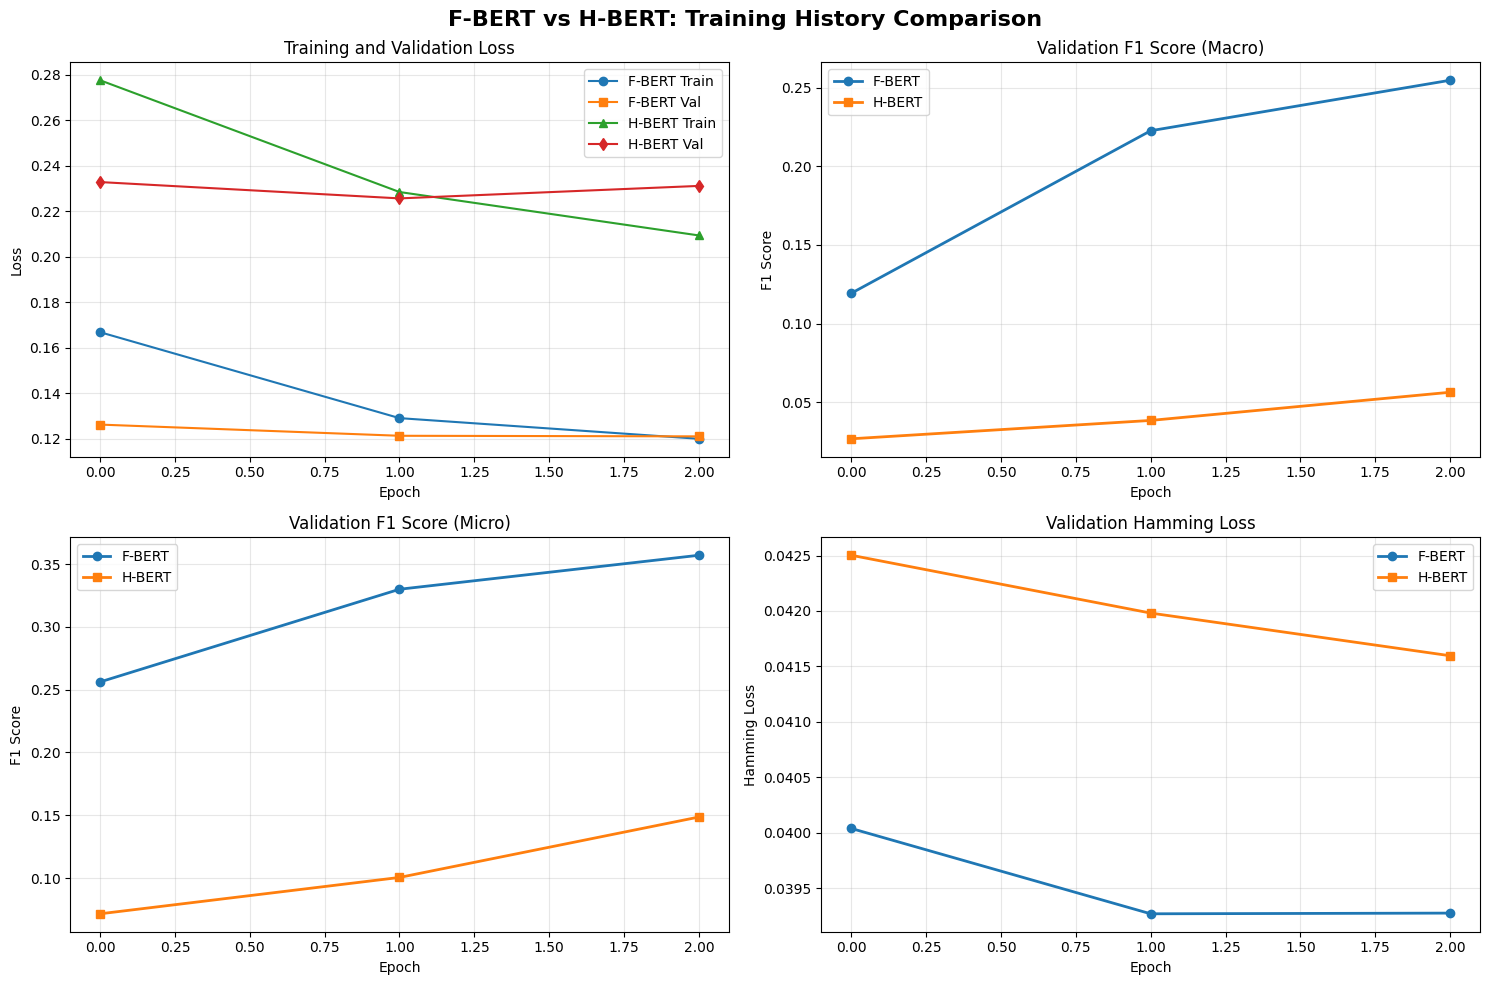

Training history visualization saved as 'dual_bert_training_history.png'


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('F-BERT vs H-BERT: Training History Comparison', fontsize=16, fontweight='bold')

axes[0, 0].plot(fbert_history['train_loss'], label='F-BERT Train', marker='o')
axes[0, 0].plot(fbert_history['val_loss'], label='F-BERT Val', marker='s')
axes[0, 0].plot(hbert_history['train_loss'], label='H-BERT Train', marker='^')
axes[0, 0].plot(hbert_history['val_loss'], label='H-BERT Val', marker='d')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(fbert_history['val_f1_macro'], label='F-BERT', marker='o', linewidth=2)
axes[0, 1].plot(hbert_history['val_f1_macro'], label='H-BERT', marker='s', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('F1 Score')
axes[0, 1].set_title('Validation F1 Score (Macro)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(fbert_history['val_f1_micro'], label='F-BERT', marker='o', linewidth=2)
axes[1, 0].plot(hbert_history['val_f1_micro'], label='H-BERT', marker='s', linewidth=2)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('F1 Score')
axes[1, 0].set_title('Validation F1 Score (Micro)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(fbert_history['val_hamming'], label='F-BERT', marker='o', linewidth=2)
axes[1, 1].plot(hbert_history['val_hamming'], label='H-BERT', marker='s', linewidth=2)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Hamming Loss')
axes[1, 1].set_title('Validation Hamming Loss')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('dual_bert_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("Training history visualization saved as 'dual_bert_training_history.png'")

In [ ]:
torch.save(fbert.state_dict(), '/kaggle/working/fbert_final_model.pt')
torch.save(hbert.state_dict(), '/kaggle/working/hbert_final_model.pt')

metrics = {
    'F-BERT': {
        'test_loss': float(fbert_test_loss),
        'test_hamming_loss': float(fbert_test_hamming),
        'test_f1_micro': float(fbert_test_f1_micro),
        'test_f1_macro': float(fbert_test_f1_macro),
        'training_epochs': len(fbert_history['train_loss'])
    },
    'H-BERT': {
        'test_loss': float(hbert_test_loss),
        'test_hamming_loss': float(hbert_test_hamming),
        'test_f1_micro': float(hbert_test_f1_micro),
        'test_f1_macro': float(hbert_test_f1_macro),
        'training_epochs': len(hbert_history['train_loss'])
    }
}

with open('dual_bert_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=4)

print("✓ Models saved")
print("✓ Metrics saved as 'dual_bert_metrics.json'")

✓ Models saved
✓ Metrics saved as 'dual_bert_metrics.json'


In [24]:
print("\n" + "="*80)
print("DUAL BERT MODEL: FINAL SUMMARY")
print("="*80)

print("\n📊 MODEL ARCHITECTURE COMPARISON:")
print(f"  F-BERT (Flat):")
print(f"    • Architecture: Single BERT + Direct classification")
print(f"    • Prediction layers: 768 → 256 → {num_labels}")
print(f"    • Total parameters: {sum(p.numel() for p in fbert.parameters()):,}")
print(f"\n  H-BERT (Hierarchical):")
print(f"    • Architecture: Single BERT + Two-level hierarchy")
print(f"    • Level 1: Predict {num_categories} categories (positive/negative/ambiguous)")
print(f"    • Level 2: Predict {num_labels} emotions conditioned on categories")
print(f"    • Total parameters: {sum(p.numel() for p in hbert.parameters()):,}")

print("\n📈 PERFORMANCE COMPARISON:")
print(f"  Metric                  │   F-BERT   │  H-BERT  │ Better Model")
print(f"  ─────────────────────────┼────────────┼──────────┼─────────────")
print(f"  F1 Score (Macro)        │   {fbert_test_f1_macro:.4f}   │  {hbert_test_f1_macro:.4f}  │ {'H-BERT ✓' if hbert_test_f1_macro > fbert_test_f1_macro else 'F-BERT ✓'}")
print(f"  F1 Score (Micro)        │   {fbert_test_f1_micro:.4f}   │  {hbert_test_f1_micro:.4f}  │ {'H-BERT ✓' if hbert_test_f1_micro > fbert_test_f1_micro else 'F-BERT ✓'}")
print(f"  Hamming Loss            │   {fbert_test_hamming:.4f}   │  {hbert_test_hamming:.4f}  │ {'H-BERT ✓' if hbert_test_hamming < fbert_test_hamming else 'F-BERT ✓'}")
print(f"  Test Loss               │   {fbert_test_loss:.4f}   │  {hbert_test_loss:.4f}  │ {'H-BERT ✓' if hbert_test_loss < fbert_test_loss else 'F-BERT ✓'}")
print(f"  Training Epochs         │     {len(fbert_history['train_loss'])}      │    {len(hbert_history['train_loss'])}     │ N/A")

print("\n💡 RECOMMENDATION:")
better_model = 'H-BERT' if hbert_test_f1_macro > fbert_test_f1_macro else 'F-BERT'
print(f"  → Overall better model: {better_model}")
print(f"  → Use {better_model} for deployment")

print("\n✓ Training configuration matched with original model.ipynb")
print(f"  • Epochs: 3 (with early stopping)")
print(f"  • Train/Val/Test split: 80/10/10")
print(f"  • Learning rate: {learning_rate}")
print(f"  • Batch size: {batch_size}")
print(f"  • Max sequence length: 256")

print("\n" + "="*80)


DUAL BERT MODEL: FINAL SUMMARY

📊 MODEL ARCHITECTURE COMPARISON:
  F-BERT (Flat):
    • Architecture: Single BERT + Direct classification
    • Prediction layers: 768 → 256 → 28
    • Total parameters: 109,686,300

  H-BERT (Hierarchical):
    • Architecture: Single BERT + Two-level hierarchy
    • Level 1: Predict 3 categories (positive/negative/ambiguous)
    • Level 2: Predict 28 emotions conditioned on categories
    • Total parameters: 109,786,143

📈 PERFORMANCE COMPARISON:
  Metric                  │   F-BERT   │  H-BERT  │ Better Model
  ─────────────────────────┼────────────┼──────────┼─────────────
  F1 Score (Macro)        │   0.2472   │  0.0545  │ F-BERT ✓
  F1 Score (Micro)        │   0.3487   │  0.1361  │ F-BERT ✓
  Hamming Loss            │   0.0399   │  0.0419  │ F-BERT ✓
  Test Loss               │   0.1230   │  0.2317  │ F-BERT ✓
  Training Epochs         │     3      │    3     │ N/A

💡 RECOMMENDATION:
  → Overall better model: F-BERT
  → Use F-BERT for deployment

✓